In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import welch
from scipy.stats import circstd  # type: ignore
from tqdm import trange

from kalman_experiments import SSPE
from kalman_experiments.kalman import PerturbedP1DMatsudaKF, apply_kf
from kalman_experiments.model_selection import (
    estimate_sigmas,
    fit_kf_parameters,
    get_psd_val_from_est,
    theor_psd_ar,
    theor_psd_mk_mar,
)
from kalman_experiments.models import MatsudaParams, gen_ar_noise_coefficients

In [13]:
# Generate data
SRATE = 1000
DURATION = 10_000
CHUNK_NSAMP = int(10 * SRATE)
FREQ_GT = 6
SIGNAL_SIGMA_GT = np.sqrt(10)
NOISE_SIGMA_GT = 1
A_GT = 0.99
ALPHA = 1.5
NOISE_AR_ORDER = 1000
sim = dict(
    sines_in_white=SSPE.gen_sine_w_white(DURATION, SRATE),
    sines_in_pink=SSPE.gen_sine_w_pink(DURATION, SRATE),
    filtered_pink=SSPE.gen_filt_pink_noise_w_added_pink_noise(DURATION, SRATE),
    state_space_model_white=SSPE.gen_state_space_model_white(DURATION, SRATE),
    state_space_model_pink=SSPE.gen_state_space_model_pink(DURATION, SRATE),
)

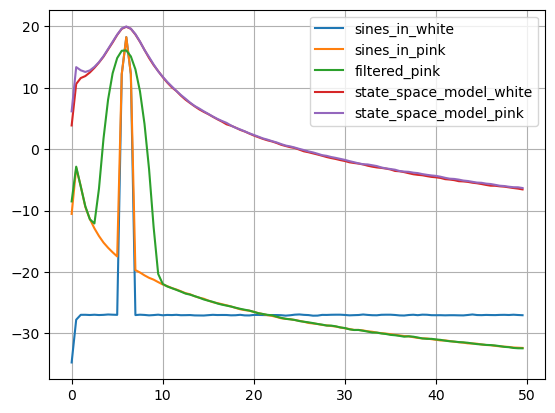

In [14]:
# Plot PSD for generated data
FREQ_LIM = 100
plt.figure()
for k, s in sim.items():
    freqs, psd = welch(s.data, fs=SRATE, nperseg=2000)
    plt.plot(freqs[:FREQ_LIM], 10 * np.log10(psd[:FREQ_LIM]), label=k)
plt.grid()
plt.legend()
plt.show()

In [15]:


TRAIN_LIMIT_SAMP = 5000
KF_NOISE_ORDER = 30
NPERSEG = 1000

fit_freqs = [6, 450]
cstd_pink = {}
cstd_white = {}
params_pink = {}
params_white = {}

for k, s in sim.items():
    #     if k != "sines_in_pink":
    #         continue
    print(f"{k:-^80}")
    train_data = s.data[:TRAIN_LIMIT_SAMP]

    freqs, psd = welch(train_data, fs=SRATE, nperseg=NPERSEG)
    est_psd_func = partial(get_psd_val_from_est, freqs=freqs, psd=psd / 2)

    # pink noise
    if k.startswith("sines"):
        A_fit = 0.9999
    elif k.startswith("filtered"):
        A_fit = 0.9999
    else:
        A_fit = 0.99
    mp = MatsudaParams(A=A_fit, freq=FREQ_GT, sr=SRATE)
    mar_psd_func = partial(theor_psd_mk_mar, s=1, mp=mp)

    if k.endswith("pink"):
        psi_pink = gen_ar_noise_coefficients(alpha=ALPHA, order=KF_NOISE_ORDER)
    else:
        psi_pink = gen_ar_noise_coefficients(alpha=0, order=1)
    ar_psd_func = partial(theor_psd_ar, ar_coef=psi_pink, sr=SRATE, s=1)

    q_s_2, r_s_2 = estimate_sigmas([mar_psd_func, ar_psd_func], est_psd_func, fit_freqs)
    q_s_est_pink, r_s_est_pink = np.sqrt(q_s_2 * SRATE), np.sqrt(r_s_2 * SRATE)
    r_s_est_pink = max(r_s_est_pink, 0.2)
    kf_pink = PerturbedP1DMatsudaKF(
        mp, q_s=q_s_est_pink, psi=psi_pink, r_s=r_s_est_pink, lambda_=1e-6
    )

    psi_white = gen_ar_noise_coefficients(alpha=0, order=1)
    ar_psd_func = partial(theor_psd_ar, ar_coef=psi_white, sr=SRATE, s=1)
    q_s_2, r_s_2 = estimate_sigmas([mar_psd_func, ar_psd_func], est_psd_func, fit_freqs)
    q_s_est_white, r_s_est_white = np.sqrt(q_s_2 * SRATE), np.sqrt(r_s_2 * SRATE)
    r_s_est_white = max(r_s_est_white, 0.2)
    #     r_s_est_white = max(r_s_est_white, 0.3)
    #     q_s_est_white = 0.02
    kf_white = PerturbedP1DMatsudaKF(
        mp, q_s=q_s_est_white, psi=psi_white, r_s=r_s_est_white, lambda_=1e-6
    )
    print(f"{q_s_est_pink=:.2f}, {r_s_est_pink=:.2f}")
    print(f"{q_s_est_white=:.2f}, {r_s_est_white=:.2f}")

    kf_pink_fit = fit_kf_parameters(train_data, kf_pink, tol=1e-3)
    params_pink[k] = (kf_pink_fit.M.A, kf_pink_fit.M.freq, kf_pink_fit.q_s, kf_pink_fit.r_s)
    kf_white_fit = fit_kf_parameters(train_data, kf_white, tol=1e-3)
    params_white[k] = (kf_white_fit.M.A, kf_white_fit.M.freq, kf_white_fit.q_s, kf_white_fit.r_s)

    cstd_pink[k] = []
    cstd_white[k] = []
    for i in trange(int(DURATION / 10)):
        data_chunk = s.data[i * CHUNK_NSAMP : (i + 1) * CHUNK_NSAMP]
        phases_chunk = s.true_phase[i * CHUNK_NSAMP : (i + 1) * CHUNK_NSAMP]

        filtered_pink = apply_kf(kf_pink_fit, data_chunk, delay=0)
        filtered_white = apply_kf(kf_white_fit, data_chunk, delay=0)
        #         filtered_white = apply_kf(kf_white, data_chunk, delay=0)

        cstd_pink[k].append(circstd(np.angle(filtered_pink) - phases_chunk) * 180 / np.pi)
        cstd_white[k].append(circstd(np.angle(filtered_white) - phases_chunk) * 180 / np.pi)
    print(np.mean(cstd_pink[k]))
    print(np.std(cstd_pink[k]))
    print(np.mean(cstd_white[k]))
    print(np.std(cstd_white[k]))

#         print(
#             "circstd:",
#             "pink=",
#             round(np.mean(cstd_pink[k]), 2),
#             "white=",
#             round(np.mean(cstd_white[k]), 2),
#         )

---------------------------------sines_in_white---------------------------------
q_s_est_pink=0.02, r_s_est_pink=1.05
q_s_est_white=0.02, r_s_est_white=1.05


Fitting KF parameters: nll=2612.10,f=6.00, A=1.0000, 0.02, 1.00:   0%| | 1/800 [00:00<10
Fitting KF parameters: nll=2612.10,f=6.00, A=1.0000, 0.02, 1.00:   0%| | 1/800 [00:00<10
100%|███████████████████████████████████████████████| 1000/1000 [08:16<00:00,  2.01it/s]


0.6285872000212188
0.04085491846958466
0.6285872000212188
0.04085491846958466
---------------------------------sines_in_pink----------------------------------
q_s_est_pink=0.02, r_s_est_pink=0.20
q_s_est_white=0.02, r_s_est_white=0.20


Fitting KF parameters: nll=-3517.40,f=6.01, A=1.0000, 0.02, 0.23:   0%| | 1/800 [00:02<3
Fitting KF parameters: nll=-4131.87,f=4.81, A=0.9995, 0.26, 0.09:   1%| | 10/800 [00:04<
100%|███████████████████████████████████████████████| 1000/1000 [09:16<00:00,  1.80it/s]


1.9111149196364345
0.7870447715220498
42.437150739085894
25.78331389687761
---------------------------------filtered_pink----------------------------------
q_s_est_pink=0.02, r_s_est_pink=0.21
q_s_est_white=0.02, r_s_est_white=0.20


Fitting KF parameters: nll=-2001.74,f=6.13, A=1.0002, 0.04, 0.43:   1%| | 6/800 [00:07<1
Fitting KF parameters: nll=-2866.69,f=4.10, A=0.9998, 0.34, 0.13:   1%| | 7/800 [00:02<0
100%|███████████████████████████████████████████████| 1000/1000 [08:47<00:00,  1.90it/s]


51.522252783066925
4.544449713955067
44.91822416004518
21.050920815684854
----------------------------state_space_model_white-----------------------------
q_s_est_pink=2.86, r_s_est_pink=0.62
q_s_est_white=2.86, r_s_est_white=0.62


Fitting KF parameters: nll=6316.98,f=5.81, A=0.9888, 3.31, 0.65:   1%| | 11/800 [00:04<0
Fitting KF parameters: nll=6316.98,f=5.81, A=0.9888, 3.31, 0.65:   1%| | 11/800 [00:04<0
100%|███████████████████████████████████████████████| 1000/1000 [07:55<00:00,  2.10it/s]


35.48433392570625
2.2585713095277766
35.48433392570625
2.2585713095277766
-----------------------------state_space_model_pink-----------------------------
q_s_est_pink=2.77, r_s_est_pink=0.20
q_s_est_white=2.77, r_s_est_white=0.20


Fitting KF parameters: nll=6187.50,f=5.73, A=0.9917, 3.31, 0.20:   1%| | 9/800 [00:13<19
Fitting KF parameters: nll=6187.23,f=5.73, A=0.9917, 3.30, 0.20:   1%| | 9/800 [00:03<05
100%|███████████████████████████████████████████████| 1000/1000 [09:07<00:00,  1.83it/s]

43.85357653434227
4.765461713757997
43.908559754331876
4.786347451246147


In [11]:
mp

MatsudaParams(A=0.99, freq=6, sr=1000)

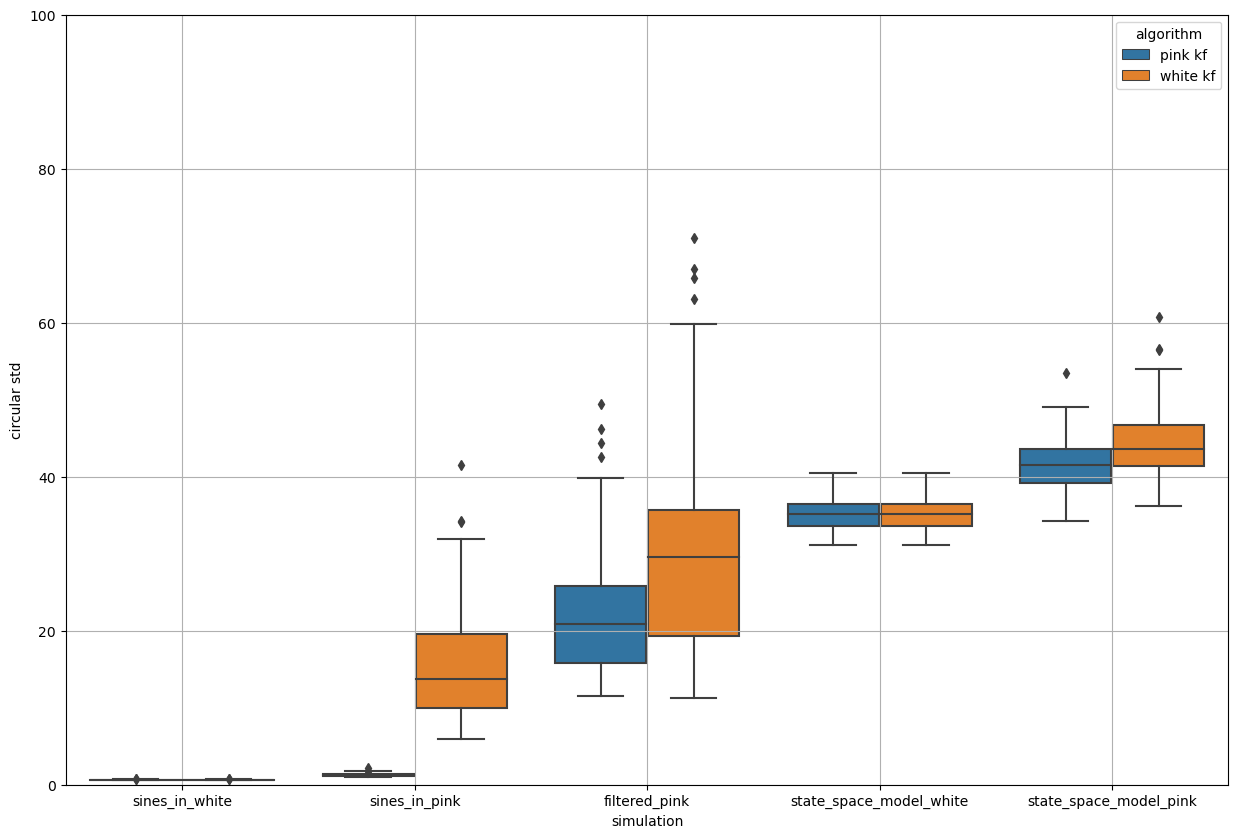

In [12]:
def grouped_barplot(df, cat, subcat, val, err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx)) - np.arange(len(subx)).mean()) / (len(subx) + 1.0)
    width = np.diff(offsets).mean()
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(
            x + offsets[i],
            dfg[val].values,
            width=width,
            label="{} {}".format(subcat, gr),
            yerr=dfg[err].values,
        )
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()


cat = "Candidate"
subcat = "Sample_Set"
val = "Values"
err = "Error"

# call the function with df from the question
df_pink = pd.DataFrame(cstd_pink)
df_pink = df_pink.T.unstack().reset_index()
df_pink["algorithm"] = "pink kf"
df_pink = df_pink.rename(
    columns={"level_0": "trial_num", "level_1": "simulation", 0: "circular std"}
)

df_white = pd.DataFrame(cstd_white)
df_white = df_white.T.unstack().reset_index()
df_white["algorithm"] = "white kf"
df_white = df_white.rename(
    columns={"level_0": "trial_num", "level_1": "simulation", 0: "circular std"}
)

df = pd.concat([df_pink, df_white])

# means = df.groupby("algorithm").mean()
# errors = df.groupby("algorithm").std()

fig = plt.figure(figsize=(15, 10))
sns.boxplot(df, hue="algorithm", x="simulation", y="circular std")
plt.ylim([0, 100])
plt.grid()
plt.show()
# grouped_barplot(df, cat, subcat, val, err)
# df.unstack()

In [ ]:
df

In [ ]:
df.to_csv("metrics.csv", index=False)

In [ ]:
df.groupby(("simulation", "algoritm")).mean()